# Test Model

In [635]:
import numpy as np

from active import split_on_ids
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from pymks import (
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
)

from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [636]:
def make_gp_model_matern():
    kernel = Matern(length_scale=1.0)
    #kernel = 0.5 * RBF(length_scale=1) + WhiteKernel(noise_level=1)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor

def make_linear_model():
    return Pipeline(steps=(
        ('poly', PolynomialFeatures(degree=3)),
        ('regressor', LinearRegression()),
    ))


In [637]:
def plot_parity(y_test, y_predict, label='Testing Data'):
    pred_data = np.array([y_test, y_predict])
    line = np.min(pred_data), np.max(pred_data)
    plt.plot(pred_data[0], pred_data[1], 'o', label=label)
    plt.plot(line, line, '-', linewidth=3, color='k')
    plt.title('Goodness of Fit', fontsize=20)
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.legend(loc=2, fontsize=15)
    return plt

In [638]:
def train_test_split_(x_data, y_data, prop, random_state=None):
    ids = np.random.choice(len(x_data), int(prop * len(x_data)), replace=False)
    x_0, x_1 = split_on_ids(x_data, ids)
    y_0, y_1 = split_on_ids(y_data, ids)
    return x_0, x_1, y_0, y_1

In [639]:
def split(x_data, y_data, train_sizes=(0.9, 0.09), random_state=None):
    x_pool, x_, y_pool, y_ = train_test_split_(
        x_data,
        y_data,
        train_sizes[0],
        random_state=random_state
    )
    x_test, x_calibrate, y_test, y_calibrate = train_test_split_(
        x_,
        y_,
        train_sizes[1] / (1 - train_sizes[0]),
        random_state=random_state
    ) 
    return x_pool, x_test, x_calibrate, y_pool, y_test, y_calibrate

In [640]:
data = np.load('data_pca51.npz')

In [641]:
x_data_pca = data['x_data_pca'][:]
y_data = data['y_data']

In [696]:
x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.6, 0.2))

In [697]:
x_train.shape

(120, 15)

In [698]:
x_test.shape

(120, 15)

In [699]:
model = make_linear_model()
#model = make_gp_model_matern()

In [700]:
model.fit(x_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('regressor', LinearRegression())])

In [701]:
y_train_predict = model.predict(x_train)

In [702]:
y_test_predict = model.predict(x_test)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

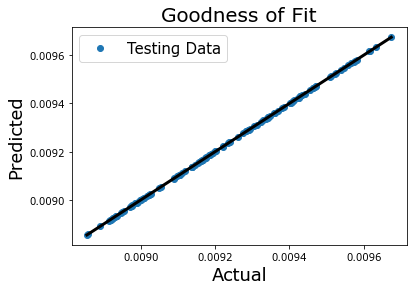

In [703]:
plot_parity(y_train, y_train_predict)

<module 'matplotlib.pyplot' from '/nix/store/c8sgkmibi2vyfw75w9vai2917j5smvq7-python3.8-matplotlib-3.3.1/lib/python3.8/site-packages/matplotlib/pyplot.py'>

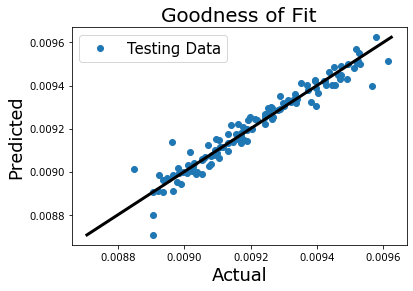

In [704]:
plot_parity(y_test, y_test_predict)

In [705]:
print(r2_score(y_test, y_test_predict))
#print(y_test.shape)
#print(y_test)
print(model.score(x_test, y_test))
#sklearn.metrics.r2_score()

0.9349095261192889
0.9349095261192889


In [713]:
scores = []
for _ in range(20):
    x_pool, x_test, x_train, y_pool, y_test, y_train = split(x_data_pca, y_data, (0.75, 0.2))
    model = make_linear_model()
    model.fit(x_train, y_train)
    print(x_train.shape)
    scores += [model.score(x_test, y_test)]
    
print(scores)

(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
(30, 15)
[0.5570214039574017, 0.4206152140549174, 0.18357165178428514, 0.6317831981741826, 0.42203945785631036, 0.8062241621250912, 0.45994420812889414, 0.7074291367604504, 0.859872218063946, 0.7151687815660607, 0.8443753722642442, 0.8400501637524821, 0.4448723330589689, 0.7311990740307388, 0.6228977645816314, 0.7779700527956738, 0.7071541225384932, 0.3733944347816617, 0.8239043390270282, 0.7416073046326681]


In [672]:
np.mean(scores)

0.9949383685747861

In [673]:
np.std(scores)

0.0005963329904012462